# Ensemble Pursuit: an algorithm for finding  overlapping clusters of correlated neurons in large-scale recordings

In [1]:
from scipy import io
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from EnsemblePursuit.EnsemblePursuit import new_ensemble

## Abstract

Large populations of neurons coordinate their activity to process shared sensory inputs and encode internal behavioral states. To extract these patterns of coordination in large datasets, we developed a fast greedy algorithm based on dictionary learning which extracts correlated and overlapping ensembles of cells from calcium imaging recordings. The learning algorithm continuously initializes and extracts new dictionary terms greedily from the residuals of the cost function given the current active set of dictionary elements. It shares this strategy with projection pursuit methods like independent components analysis, and we thus called the algorithm ”ensemble pursuit”. The method has a tunable parameter to control the sparsity of the ensembles, e.g. how many cells they include on average. Because one cell typically belongs to multiple ensembles, the model is more flexible than traditional clustering approaches. We applied the algorithm to simultaneous calcium imaging recordings of tens of thousands neurons from V1 primary cortical area of the mouse and evaluated the encoding of stimulus and behavioral variables by groups of cells extracted by the algorithm.

## Introduction

To begin our investigations, we ask the basic question: "How is the computation organized at the circuit level in the brain? Are there redundant functional modules in the cortical code, with some neurons representing the same information? Can we extract from high-dimensional data groupings of cells that tend respond similarly to stimuli or share variability through behavioral variables encoded internally by the brain?" We develop a mathematical framework for rigorously exploring these questions. 

Two techniques used to understand high-dimensional data are matrix factorization and clustering. The most famous and widely employed algorithm for matrix factorization method is Principal Components Analysis (PCA). It minimizes the following unconstrained reconstruction cost function:
$$\text{Cost} = \| X - U \cdot V\|^2 $$
In PCA, $U$ is a dense matrix. In contrast, for clustering methods the rows of $U$ have only one non-zero element, which is either fixed at 1, or allowed to take on a scalar positive value. This extreme sparsity constraint makes clustering a highly interpretable method: it groups together datapoints that are similar. However, it has the caveat of only accounting for a small fraction of the variance of most datasets $X$. Ensemble Pursuit is a matrix  factorization algorithm that adds an additional constraint to the reconstruction cost function: 
$$\text{Cost} = \| X - U\cdot V\|^2 + \lambda \|U\|_0 \label{cost_function} $$
By adding a tunable parameter ($\lambda$) as an L0 sparsity penalty to the columns of the matrix $U$ we can steer the algorithm to find solutions in between the hard constraints of clustering (a neuron can belong to only one cluster) and the uninterpretable factors extracted by unconstrained PCA (all neurons belong to all clusters).

Thus, ensembles in this framework are cells that belong to the components demarcated by $U$. $V$ represents the average temporal evolution of the neurons in the ensemble.

## Ensemble Pursuit Algorithm


$\newcommand{\vv}{\vec{v}}
\newcommand{\vx}{\vec{x}}
\newcommand{\vu}{\vec{u}}
$


Consider $X$ to be a matrix of neurons by timepoints. The goal is to find one ensemble of neurons that have very similar activity over time. We achieve this objective by greedily adding neurons to the ensemble by picking neurons whose variance is best explained by the ensemble. After adding each neuron, we recompute the mean activity of the neurons so far in the ensemble, and continue adding neurons that are most correlated to this mean activity. We stop when there are no neurons left correlated to the ensemble above a threshold value $\lambda$. 

We developed a method for initializing the ensemble based on the k-means algorithm, but for now for exposition purposes, let's assume we initialize a seed time course for the ensemble to be the time course of a seed neuron. In our initial experiments we picked this seed neuron to be a neuron that is most correlated on average to its neighbors and this method worked well in terms of finding ensembles that gave a high stimulus decoding accuracy, bu the method was too slow because it required sorting a large array of the size $O(\text{neurons}^2)$. 

Thus, if we pick a seed neuron $k$ to start from, that sets the corresponding $u_k = 1$. To set $\vv$ given this new $\vu$, we inspect the cost function  and observe that the best setting of $\vv$ is $\vv = \vx_k$, where $x_k$ is the row in $X$ corresponding to the activity of neuron $k$. Fixing this $\vv$, we look to activate a new neuron in $\vu$ that is best explained by $\vv$. For each neuron $j$, we thus compute its potential explained variance, if that neuron was assigned to this ensemble

$$
    \Delta_j  = \|\vx_j\|^2 - \|\vx_j - u_j \vv^\top\|^2 - \lambda
$$

Taking the derivative of the cost function yields the following expression:

$$
    \Delta_j = \frac{\max\left(0, \vx_j^\top \vv \right)^2}{\|\vv\|^2} - \lambda \label{delta_cost}
$$

Among the neurons we greedily pick the next neuron to add to the ensemble neuron as the one that leads to the highest reduction of the cost and if the neuron is above the regularization term $\lambda$.

Let's see this work on data.

The data can be downloaded here https://figshare.com/articles/Recordings_of_ten_thousand_neurons_in_visual_cortex_in_response_to_2_800_natural_images/6845348 The data comes from the publication "High-dimensional geometry of population responses in visual cortex", Stringer and Pachitariu et al, 2019, Nature.

Shape of the data matrix, neurons by timepoints: (18795, 30766)
Cost vector shape (18795,)


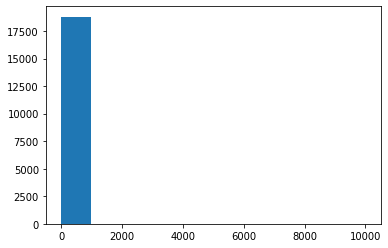

In [12]:
#CHANGE ME
data_path='/home/maria/Documents/data_for_suite2p/TX39/'
dt=1
#Load in data
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
S=zscore(S[:,:10000],axis=1)

#Pick a random seed neuron
seed_neuron=S[200,:]
plt.show()

cost_vector=np.clip(S@seed_neuron,a_min=0,a_max=None)**2/np.sum(seed_neuron**2)
print('Cost vector shape %s' % str(cost_vector.shape))
plt.hist(cost_vector)
plt.show()
print(co)


In [ ]:
stat = np.load((data_path+'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 